In [6]:
import numpy as np

from rocketpy import Environment, Flight, Function, Rocket, MonteCarlo, SolidMotor, utilities
from rocketpy.stochastic import (
    StochasticEnvironment,
    StochasticFlight,
    StochasticParachute,
    StochasticRocket,
    StochasticSolidMotor,
)

In [22]:
parameters = {
    # Mass Details
    "rocket_mass": 19478 / 1000,  # propellant mass = 1.37
    "CG": -2.71,

    # Aerodynamic Details
    "inertia_i": 0.968,
    "inertia_z": 0.014,
    "radius": 157 / 2000,
    "nozzle_dist_from_tip": -3.71+0.0762,
    "power_off_drag": "./CD_Mach.csv",
    "power_on_drag": "./CD_Mach.csv",
    "nose_length": 0.838,
    "nfins": 4,
    "fin_thickness": 13 / 1000,
    "fin_dist_from_tip": -3.2018,
    "tail_top_radius": 157 / 2000,
    "tail_bottom_radius": 127 / 2000,
    "tail_length": 76.2 / 1000,
    "tail_dist_from_tip": -3.71+0.0762,

    # Launch and Environment Details
    "wind_direction": 0,
    "wind_speed": 2,
    "inclination": 90, # Relative to ground
    "heading": 45,
    "rail_length": 12,

    # Parachute Details
    "CdS_drogue": 1.16,
    "CdS_main": 2.92,
    "lag_rec": 2, # Lag between chute deployment and inflation,
    "main_deploy_alt": 500
}

In [23]:
# Environment conditions
env = Environment(
    latitude=31.049806,
    longitude=103.547306, # Spaceport
    date=(2025, 12, 10, 12),
    elevation=17,
)
env.set_atmospheric_model(type="Ensemble", file="GEFS")

env.max_expected_height = 12000

oc_open: server error retrieving url: code=0 message="/gens_bc/gens20251208/gep_all_06z is not an available dataset"


Gravity Details

Acceleration of gravity at surface level:    9.7940 m/s²
Acceleration of gravity at  12.000 km (ASL): 9.7571 m/s²


Launch Site Details

Launch Date: 2025-12-10 12:00:00 UTC
Launch Site Latitude: 31.04981°
Launch Site Longitude: 103.54731°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 934102.29 E    3444018.42 N
Launch Site UTM zone: 47R
Launch Site Surface Elevation: 17.0 m


Atmospheric Model Details

Atmospheric Model Type: Ensemble
Ensemble Maximum Height: 12.000 km
Ensemble Time Period: from 2025-12-08 00:00:00 to 2025-12-24 00:00:00 utc
Ensemble Hour Interval: 6 hrs
Ensemble Latitude Range: From -90.0° to 90.0°
Ensemble Longitude Range: From 0.0° to 359.5°
Number of Ensemble Members: 31
Selected Ensemble Member: 0 (Starts from 0)


Surface Atmospheric Conditions

Surface Wind Speed: 0.91 m/s
Surface Wind Direction: 112.49°
Surface Wind Heading: 292.49°
Surface Pressure: 1000.00 hPa
Surface Temperature: 290.27 K
Surface Air Density: 1.200 kg/m³
Surface

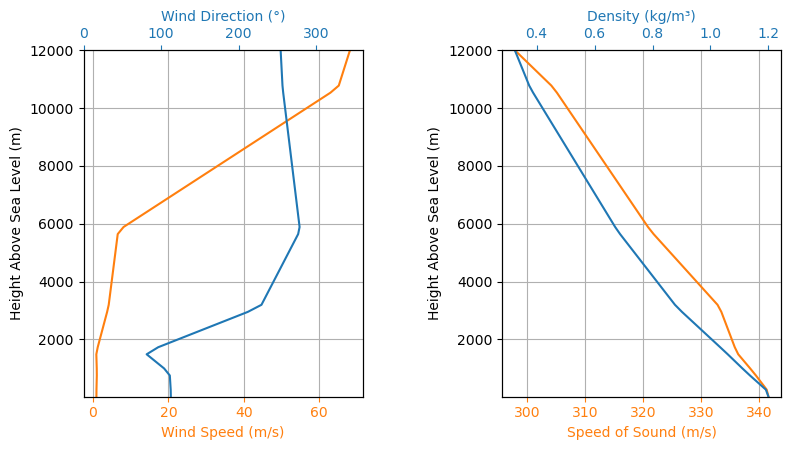

In [24]:
env.info()

In [25]:
compmotor = SolidMotor(
    thrust_source="Motor/2026_Comp_Motor.eng",
    dry_mass=15.876,
    dry_inertia=(0, 0, 0),
    center_of_dry_mass_position=0.6,
    grains_center_of_mass_position=0.6,
    grain_number=4,
    grain_separation=1.5 / 1000,
    grain_density=1670, # TRT Red
    grain_outer_radius=65 / 1000,
    grain_initial_inner_radius=50.8 / 2000,
    grain_initial_height=228.6 / 1000,
    nozzle_radius=104.0892 / 2000,
    throat_radius=35.56 / 2000,
    interpolation_method="linear",
    nozzle_position=0,
    coordinate_system_orientation="nozzle_to_combustion_chamber",
)

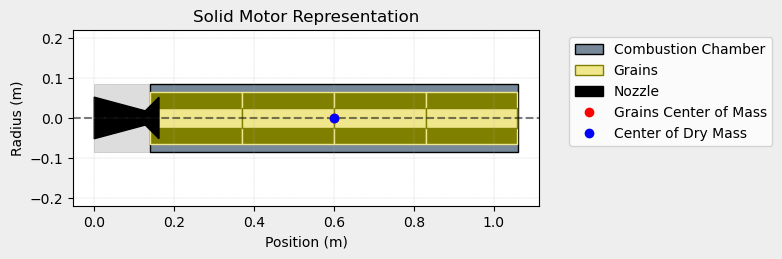

In [26]:
compmotor.plots.draw()

Nozzle Details
Nozzle Radius: 0.0520446 m
Nozzle Throat Radius: 0.01778 m

Grain Details
Number of Grains: 4
Grain Spacing: 0.0015 m
Grain Density: 1670 kg/m3
Grain Outer Radius: 0.065 m
Grain Inner Radius: 0.0254 m
Grain Height: 0.2286 m
Grain Volume: 0.003 m3
Grain Mass: 4.293 kg

Motor Details
Total Burning Time: 4.684 s
Total Propellant Mass: 17.174 kg
Structural Mass Ratio: 0.480
Average Propellant Exhaust Velocity: 2127.474 m/s
Average Thrust: 7800.340 N
Maximum Thrust: 8335.3239 N at 2.532 s after ignition.
Total Impulse: 36536.791 Ns



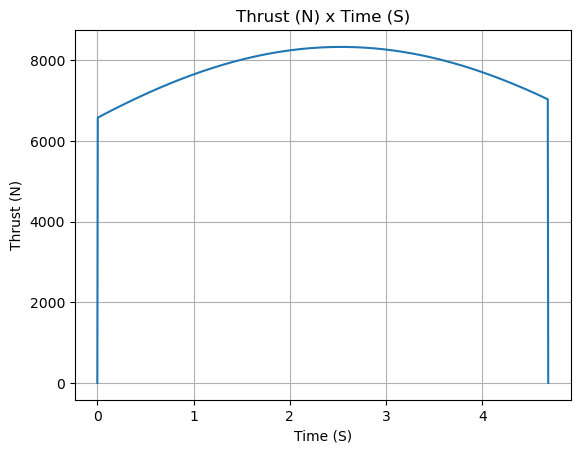

In [27]:
compmotor.info()

In [28]:
IREC2026 = Rocket(
    radius=parameters.get("radius"),
    mass=parameters.get("rocket_mass"),
    inertia=(
        parameters.get("inertia_i"),
        parameters.get("inertia_i"),
        parameters.get("inertia_z"),
    ),
    power_off_drag=parameters.get("power_off_drag"),
    power_on_drag=parameters.get("power_on_drag"),
    center_of_mass_without_motor=parameters.get("CG"),
)
IREC2026.set_rail_buttons(-2.75, -3.5)
IREC2026.add_motor(motor=compmotor, position=parameters.get("nozzle_dist_from_tip"))

In [29]:
nose_cone = IREC2026.add_nose(
    length=parameters.get("nose_length"),
    kind="von karman",
    position=0,
)

fin_set = IREC2026.add_trapezoidal_fins(
    parameters.get("nfins"),
    span = 16.5 / 100,
    sweep_length = 43.2 / 100,
    root_chord = 43.2 / 100,
    tip_chord = 7.62 / 100,
    position=parameters.get("fin_dist_from_tip"),
)

tail = IREC2026.add_tail(
    top_radius=parameters.get("tail_top_radius"),
    bottom_radius=parameters.get("tail_bottom_radius"),
    length=parameters.get("tail_length"),
    position=parameters.get("tail_dist_from_tip"),
)

In [30]:
drogue = IREC2026.add_parachute(
    "Drogue",
    cd_s=parameters.get("CdS_drogue"),
    trigger="apogee",
    lag=parameters.get("lag_rec"),
)

main = IREC2026.add_parachute(
    "Main",
    cd_s=parameters.get("CdS_main"),
    trigger=parameters.get("main_deploy_alt"),
    lag=parameters.get("lag_rec"),
)

In [31]:
# airbrake = IREC2026.add_air_brakes(
#     drag_coefficient_curve="./air_brake_cd.csv",
#     controller_function=controller_function,
#     sampling_rate=10,
#     reference_area=None,
#     clamp=True,
#     initial_observed_variables=[0, 0, 0],
#     override_rocket_drag=False,
#     name="Airbrake",
# )

# airbrake.all_info()

In [32]:
IREC2026.info()


Inertia Details

Rocket Mass: 19.478 kg (without motor)
Rocket Dry Mass: 35.354 kg (with unloaded motor)
Rocket Loaded Mass: 52.528 kg
Rocket Structural Mass Ratio: 0.673
Rocket Inertia (with unloaded motor) 11: 1.885 kg*m2
Rocket Inertia (with unloaded motor) 22: 1.885 kg*m2
Rocket Inertia (with unloaded motor) 33: 0.014 kg*m2
Rocket Inertia (with unloaded motor) 12: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 13: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 23: 0.000 kg*m2

Geometrical Parameters

Rocket Maximum Radius: 0.0785 m
Rocket Frontal Area: 0.019359 m2

Rocket Distances
Rocket Center of Dry Mass - Center of Mass without Motor: 0.145 m
Rocket Center of Dry Mass - Nozzle Exit: 0.778 m
Rocket Center of Dry Mass - Center of Propellant Mass: 0.178 m
Rocket Center of Mass - Rocket Loaded Center of Mass: 0.058 m


Aerodynamics Lift Coefficient Derivatives

Nose Cone Lift Coefficient Derivative: 2.000/rad
Fins Lift Coefficient Derivative: 9.142/rad
Tail Lift Coefficient De

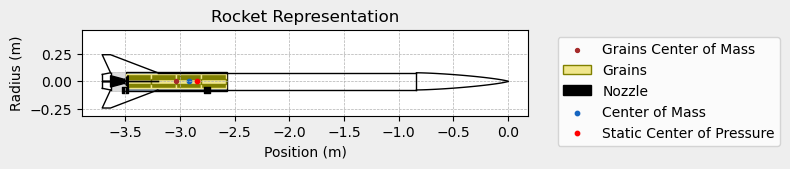

In [33]:
IREC2026.draw()

In [34]:
# Flight
test_flight = Flight(
    rocket=IREC2026,
    environment=env,
    rail_length=parameters.get("rail_length"),
    inclination=parameters.get("inclination"),
    heading=parameters.get("heading"),
    name="Rocket Ascent"
)


Initial Conditions

Initial time: 0.000 s
Position - x: 0.00 m | y: 0.00 m | z: 17.00 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude (quaternions) - e0: 1.000 | e1: 0.000 | e2: 0.000 | e3: 0.000
Euler Angles - Spin φ : -180.00° | Nutation θ: 0.00° | Precession ψ: 180.00°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s | ω3: 0.00 rad/s
Initial Stability Margin: -0.420 c


Surface Wind Conditions

Frontal Surface Wind Speed: -0.35 m/s
Lateral Surface Wind Speed: 0.84 m/s


Launch Rail

Launch Rail Length: 12 m
Launch Rail Inclination: 90.00°
Launch Rail Heading: 45.00°


Rail Departure State

Rail Departure Time: 0.432 s
Rail Departure Velocity: 52.633 m/s
Rail Departure Stability Margin: -0.385 c
Rail Departure Angle of Attack: 0.990°
Rail Departure Thrust-Weight Ratio: 14.138
Rail Departure Reynolds Number: 5.512e+05


Burn out State

Burn out time: 4.684 s
Altitude at burn out: 1467.752 m (ASL) | 1450.752 m (AGL)
Rocket speed at burn out: 409.873 m/s
Freestream v

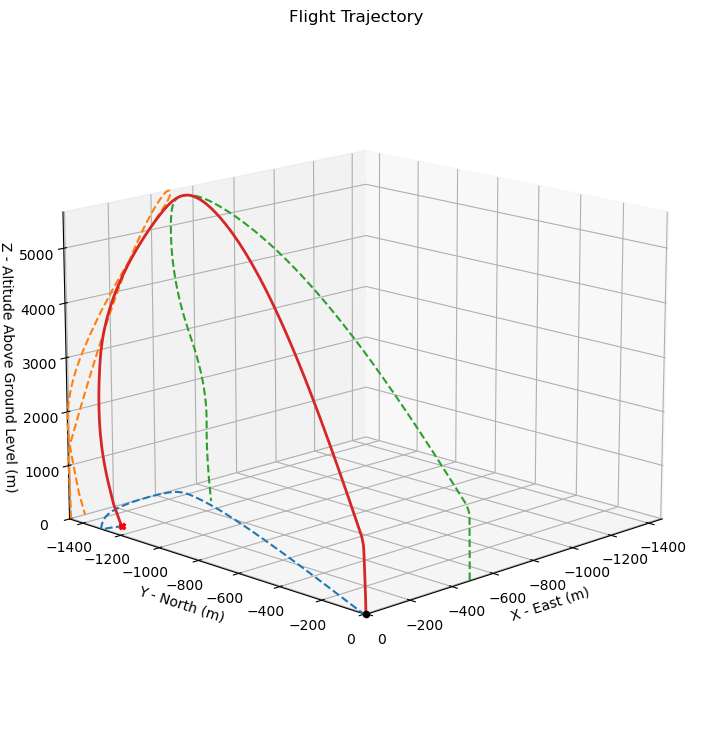

In [35]:
test_flight.info()
test_flight.plots.trajectory_3d()

In [ ]:
# utilities.fin_flutter_analysis(parameters.get("fin_thickness"), 19000, test_flight, see_prints=True, see_graphs=True)

In [ ]:
stochastic_env = StochasticEnvironment(
    environment=env,
    ensemble_member=list(range(env.num_ensemble_members)),
)

stochastic_env.visualize_attributes()

In [ ]:
stochastic_compmotor = StochasticSolidMotor(
    solid_motor=compmotor,
    grains_center_of_mass_position=0.001,
    grain_density=100,
    grain_separation=1 / 1000,
    grain_initial_height=1 / 1000,
    grain_initial_inner_radius=0.375 / 1000,
    grain_outer_radius=0.375 / 1000,
    total_impulse=(34000, 2000),
    throat_radius=0.5 / 1000,
    nozzle_radius=0.5 / 1000,
    nozzle_position=0.001,
)

stochastic_compmotor.visualize_attributes()

In [ ]:
stochastic_rocket = StochasticRocket(
    rocket=IREC2026,
    mass=1,
    inertia_11=0.1,
    inertia_22=0.1,
    inertia_33=0.01,
    center_of_mass_without_motor=0,
)

stochastic_main = StochasticParachute(
    parachute=main,
    cd_s=0.1,
    lag=0.1,
)

stochastic_drogue = StochasticParachute(
    parachute=drogue,
    cd_s=0.05,
    lag=0.2,
)

stochastic_rocket.add_motor(stochastic_compmotor, position=0.001)
stochastic_rocket.add_parachute(stochastic_main)
stochastic_rocket.add_parachute(stochastic_drogue)

stochastic_rocket.visualize_attributes()

In [ ]:
stochastic_flight = StochasticFlight(
    flight=test_flight,
    inclination=1,
    heading=2,
)
stochastic_flight.visualize_attributes()

In [ ]:
test_dispersion = MonteCarlo(
    filename="IREC2026_monte_carlo",
    environment=stochastic_env,
    rocket=stochastic_rocket,
    flight=stochastic_flight,
)

test_dispersion.simulate(
    number_of_simulations=500,
    parallel=True,
    n_workers=64,
)

In [ ]:
test_dispersion.plots.ellipses(xlim=(-1000, 1000), ylim=(-1000, 1000))

In [ ]:
test_dispersion.plots.all()

In [ ]:
test_dispersion.export_ellipses_to_kml(
    filename="IREC2026_monte_carlo.kml",
    origin_lat=env.latitude,
    origin_lon=env.longitude,
)